In [1]:
import cv2
import numpy as np
import keras.models

import digit_detector.region_proposal as rp
import digit_detector.show as show
import digit_detector.detect as detector
import digit_detector.file_io as file_io
import digit_detector.preprocess as preproc
import digit_detector.classify as cls

detect_model = "detector_model.hdf5"
recognize_model = "recognize_model.hdf5"

mean_value_for_detector = 107.524
mean_value_for_recognizer = 112.833

model_input_shape = (32,32,1)
# DIR = '../datasets/svhn/train'
DIR = 'tests/imgs'

C:\Users\Shi Yuan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 1. image files
img_files = file_io.list_files(directory=DIR, pattern="*.*", recursive_option=False, n_files_to_sample=None, random_order=False)

preproc_for_detector = preproc.GrayImgPreprocessor(mean_value_for_detector)
preproc_for_recognizer = preproc.GrayImgPreprocessor(mean_value_for_recognizer)

char_detector = cls.CnnClassifier(detect_model, preproc_for_detector, model_input_shape)
char_recognizer = cls.CnnClassifier(recognize_model, preproc_for_recognizer, model_input_shape)

digit_spotter = detector.DigitSpotter(char_detector, char_recognizer, rp.MserRegionProposer())

# for img_file in img_files[0:]:
#     # 2. image
#     img = cv2.imread(img_file)

#     digit_spotter.run(img, threshold=0.5, do_nms=True, nms_threshold=0.1)

C:\Users\Shi Yuan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras\engine\topology.py:1271: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_1", activity_regularizer=None, trainable=True, input_dtype="float32", batch_input_shape=[None, 32,..., activation="linear", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
C:\Users\Shi Yuan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras\engine\topology.py:1271: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_2", activity_regularizer=None, trainable=True, activation="linear", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=No

In [4]:
# test on whole folder with cv show
for img_file in img_files[0:]:
    # 2. image
    img = cv2.imread(img_file)

    digit_spotter.run(img, threshold=0.5, do_nms=True, nms_threshold=0.1)

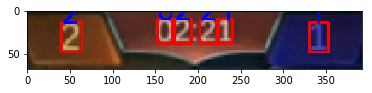

(array([[ 14,  48,  40,  64],
        [ 10,  38, 172, 192],
        [ 10,  38, 202, 222],
        [ 10,  38, 224, 240],
        [ 14,  48, 330, 352],
        [ 10,  38, 152, 170]]),
 array([0.99998724, 0.99996936, 0.9999565 , 0.98938787, 0.93346465,
        0.88241506], dtype=float32),
 array([2, 2, 2, 1, 1, 0], dtype=int64))

In [3]:
# test on single image
rootpath = DIR

img = cv2.imread(rootpath + "/WeChat Image_20190802110833.jpg")

bbs, probs, y_pred = digit_spotter.single_run(img, threshold=0.5, do_nms=True, nms_threshold=0.1)
bbs, probs, y_pred

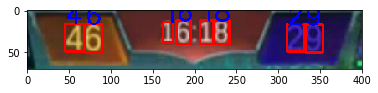

(array([[ 16,  49,  45,  68],
        [ 12,  40, 178, 195],
        [ 17,  50, 332, 353],
        [ 16,  50,  69,  89],
        [ 16,  49, 310, 331],
        [ 12,  40, 223, 241],
        [ 14,  38, 162, 174],
        [ 12,  40, 206, 222]]),
 array([0.99999845, 0.99848866, 0.9980538 , 0.9976937 , 0.9965056 ,
        0.9911344 , 0.98587775, 0.983017  ], dtype=float32),
 array([4, 6, 9, 6, 2, 8, 1, 1], dtype=int64))

In [85]:
rootpath = 'C:\\Users\\Shi Yuan\\Documents\\jupyter\\autocut\\train\\double_kill\\'

# img = cv2.imread(rootpath + "01_2_44.jpg")
# img = cv2.imread(rootpath + "02_2_34.jpg")
#img = cv2.imread(rootpath + "01_17_21.jpg") # problem
img = cv2.imread(rootpath + "01_15_30.jpg") # problem
# img = cv2.imread(rootpath + "02_1_45.jpg")


width = img.shape[1]
height = img.shape[0]

x, y, w, h = int(width/2)-int(width/12), 0, int(width/6), int(height/18)
patch = img[y:y+h, x:x+w]
patch = cv2.resize(patch, (400, 70))

bbs, probs, y_pred = digit_spotter.single_run(patch, threshold=0.5, do_nms=True, nms_threshold=0.1)
bbs, probs, y_pred

In [86]:
def grp_result(result, sort_pos, threshold=30):
    temp = [result[0]]
    myDict = {}
    j = 0
    for i in range(1,len(sort_pos)):
#         print(i,result,temp)
        if sort_pos[i]-sort_pos[i-1]>=threshold:
            myDict[j] = temp
            temp = [result[i]]
            j+=1
        else:
            temp.append(result[i])
        if i==(len(sort_pos)-1):
            myDict[j] = temp
    return myDict

def get_results(bbs, probs, y_pred):
    position = np.take(bbs,[2],axis=1).flatten()
    sort_index = np.argsort(position)
    result = np.zeros(len(position)).astype(int)
    for i,item in enumerate(sort_index):
        result[i] = y_pred[item]
    sort_pos = np.sort(position)
    result = grp_result(result,sort_pos)
    return result

result = get_results(bbs, probs, y_pred)
result

{0: [4, 6], 1: [1, 6, 1, 8], 2: [2, 9]}

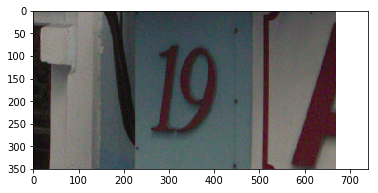

In [12]:
import matplotlib.pyplot as plt

plt.imshow(img,'brg')
plt.show()

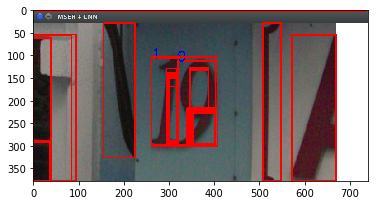

In [4]:
import sys
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

rootpath = DIR

img = cv2.imread(rootpath + "/1.png")
mser = cv2.MSER_create(_min_area=300)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
regions, boxes = mser.detectRegions(gray)

for box in boxes:
    x, y, w, h = box
    cv2.rectangle(img, (x,y),(x+w, y+h), (255, 0, 0), 2)

plt.imshow(img,'brg')
plt.show()

In [ ]:
    def detect(self, img):
        gray = self._to_gray(img)
        mser = cv2.MSER_create(_delta = 1)
        #regions = mser.detect(gray, None)
        #bounding_boxes = self._get_boxes(regions)
        #regions = Regions(img, bounding_boxes)
		
		gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		regions, boxes = mser.detectRegions(gray)

		#for box in boxes:
		#	x, y, w, h = box
		#	cv2.rectangle(img, (x,y),(x+w, y+h), (255, 0, 0), 2)